# Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    LabelEncoder,
    OrdinalEncoder,
)

# Data Preparation

In [2]:
df = pd.read_csv("data/03/spaceship_titanic.csv")

In [3]:
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False    NaN  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False    NaN  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e   NaN   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8292 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         1892 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           7699 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Missing Data

### Discovering Missing Data

We check if there are missing values in the dataset.

In [5]:
df.isnull().sum()

PassengerId        0
HomePlanet       401
CryoSleep        217
Cabin           6801
Destination      182
Age              994
VIP              203
RoomService      181
FoodCourt        183
ShoppingMall     208
Spa              183
VRDeck           188
Name             200
Transported        0
dtype: int64

In [6]:
percentage_of_missing_values_per_column = df.isnull().sum() / len(df) * 100

In [7]:
percentage_of_missing_values_per_column = (
    percentage_of_missing_values_per_column.reset_index().rename(
        columns={"index": "column_name", 0: "missing_percentage"}
    )
)

In [8]:
percentage_of_missing_values_per_column

column_name  missing_percentage
0    PassengerId            0.000000
1     HomePlanet            4.612907
2      CryoSleep            2.496261
3          Cabin           78.235362
4    Destination            2.093639
5            Age           11.434488
6            VIP            2.335212
7    RoomService            2.082135
8      FoodCourt            2.105142
9   ShoppingMall            2.392730
10           Spa            2.105142
11        VRDeck            2.162660
12          Name            2.300702
13   Transported            0.000000

The `msno.bar(df)` function presents a simple visualization of nullity by column.

<Axes: >

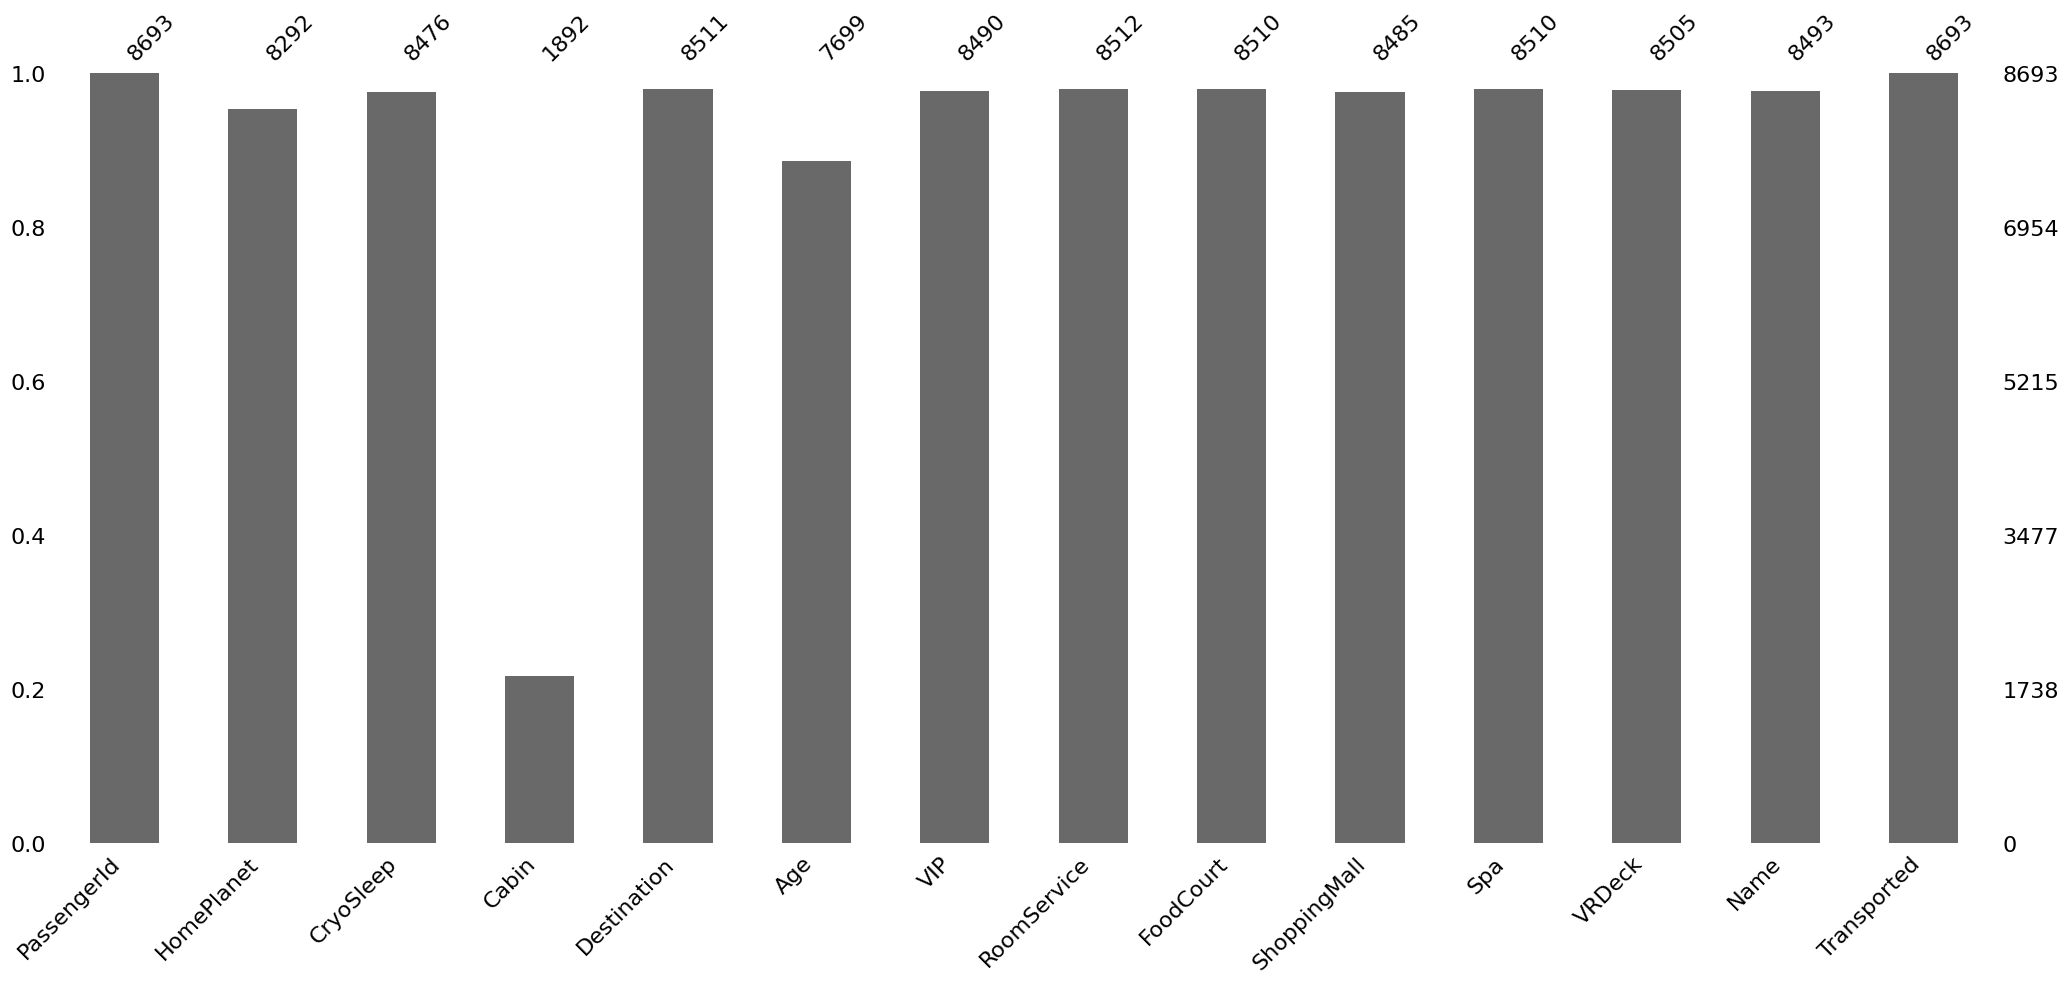

In [9]:
msno.bar(df)

The `msno.matrix(df)` function presents a nullity matrix that is a data-dense display which lets you quickly visually pick out patterns in data completion. The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

<Axes: >

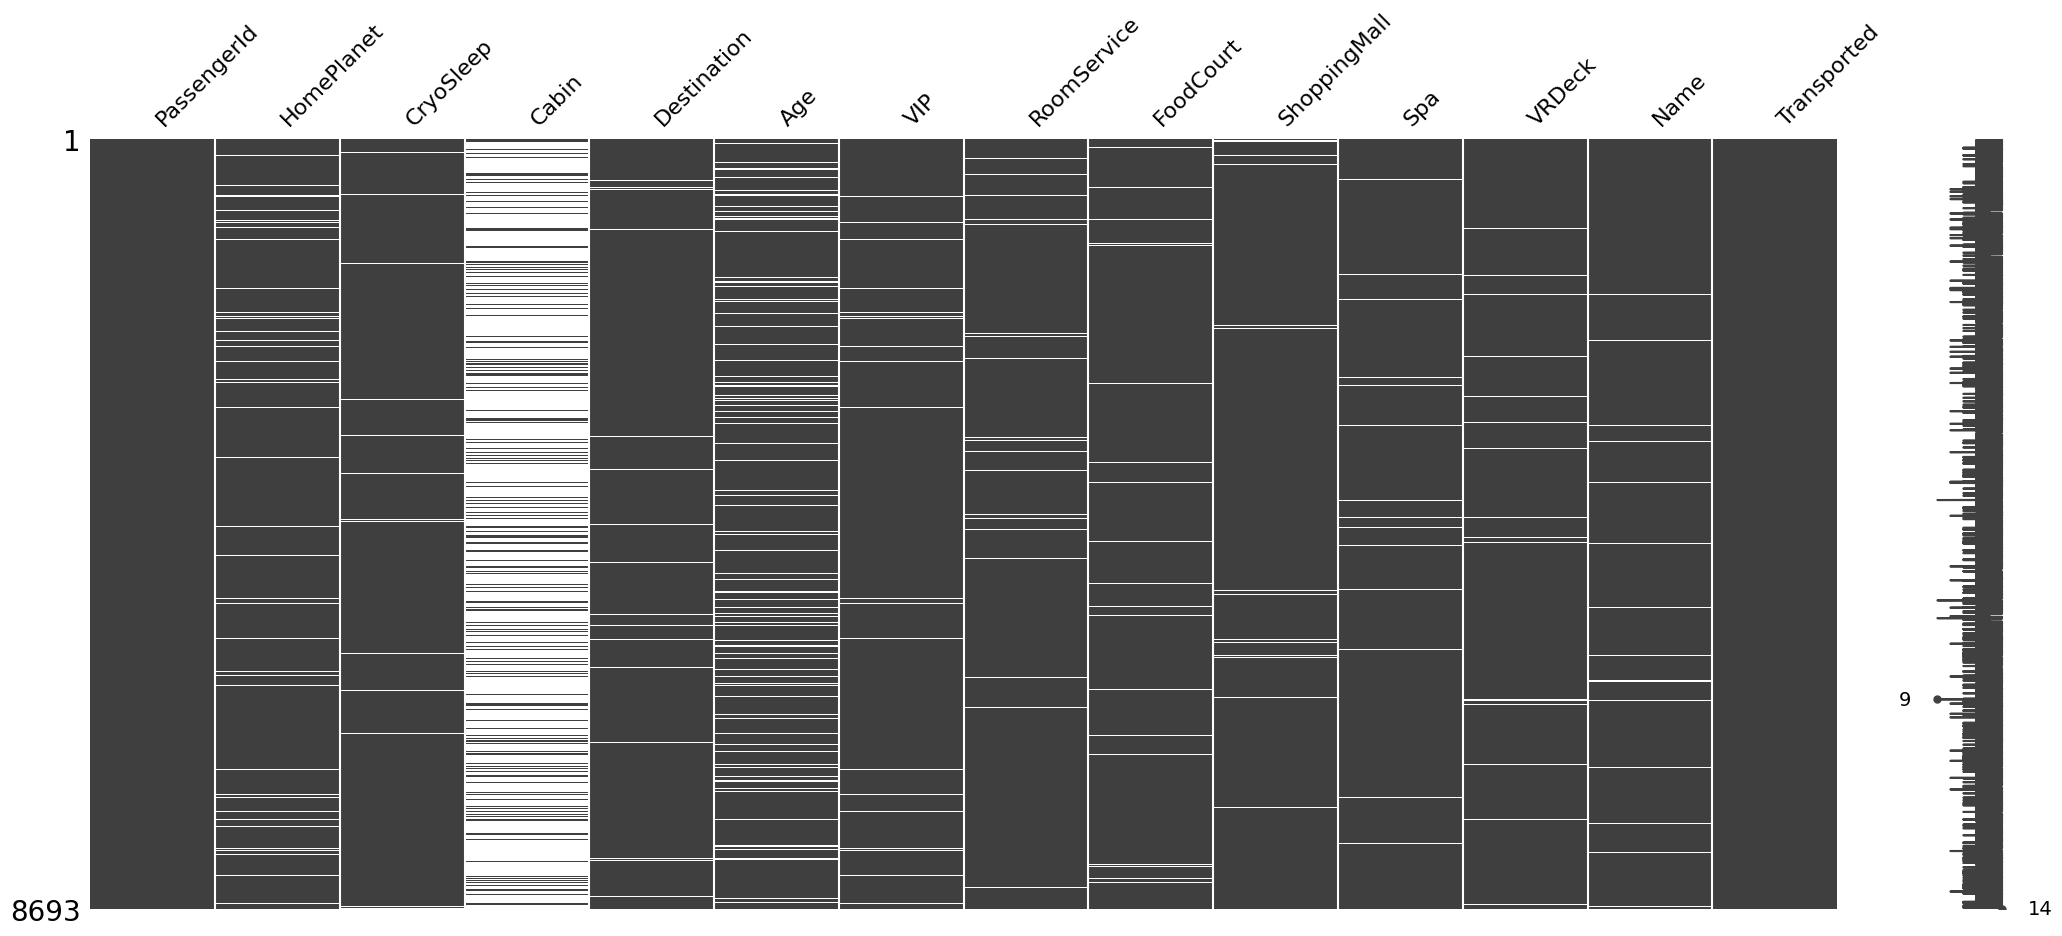

In [10]:
msno.matrix(df)

The `missingno.heatmap(df)` function presents a `seaborn` heatmap visualization of nullity correlation in the given data frame. The nullity correlation shows how strongly the presence or absence of one variable affects the presence or absence of another.

<Axes: >

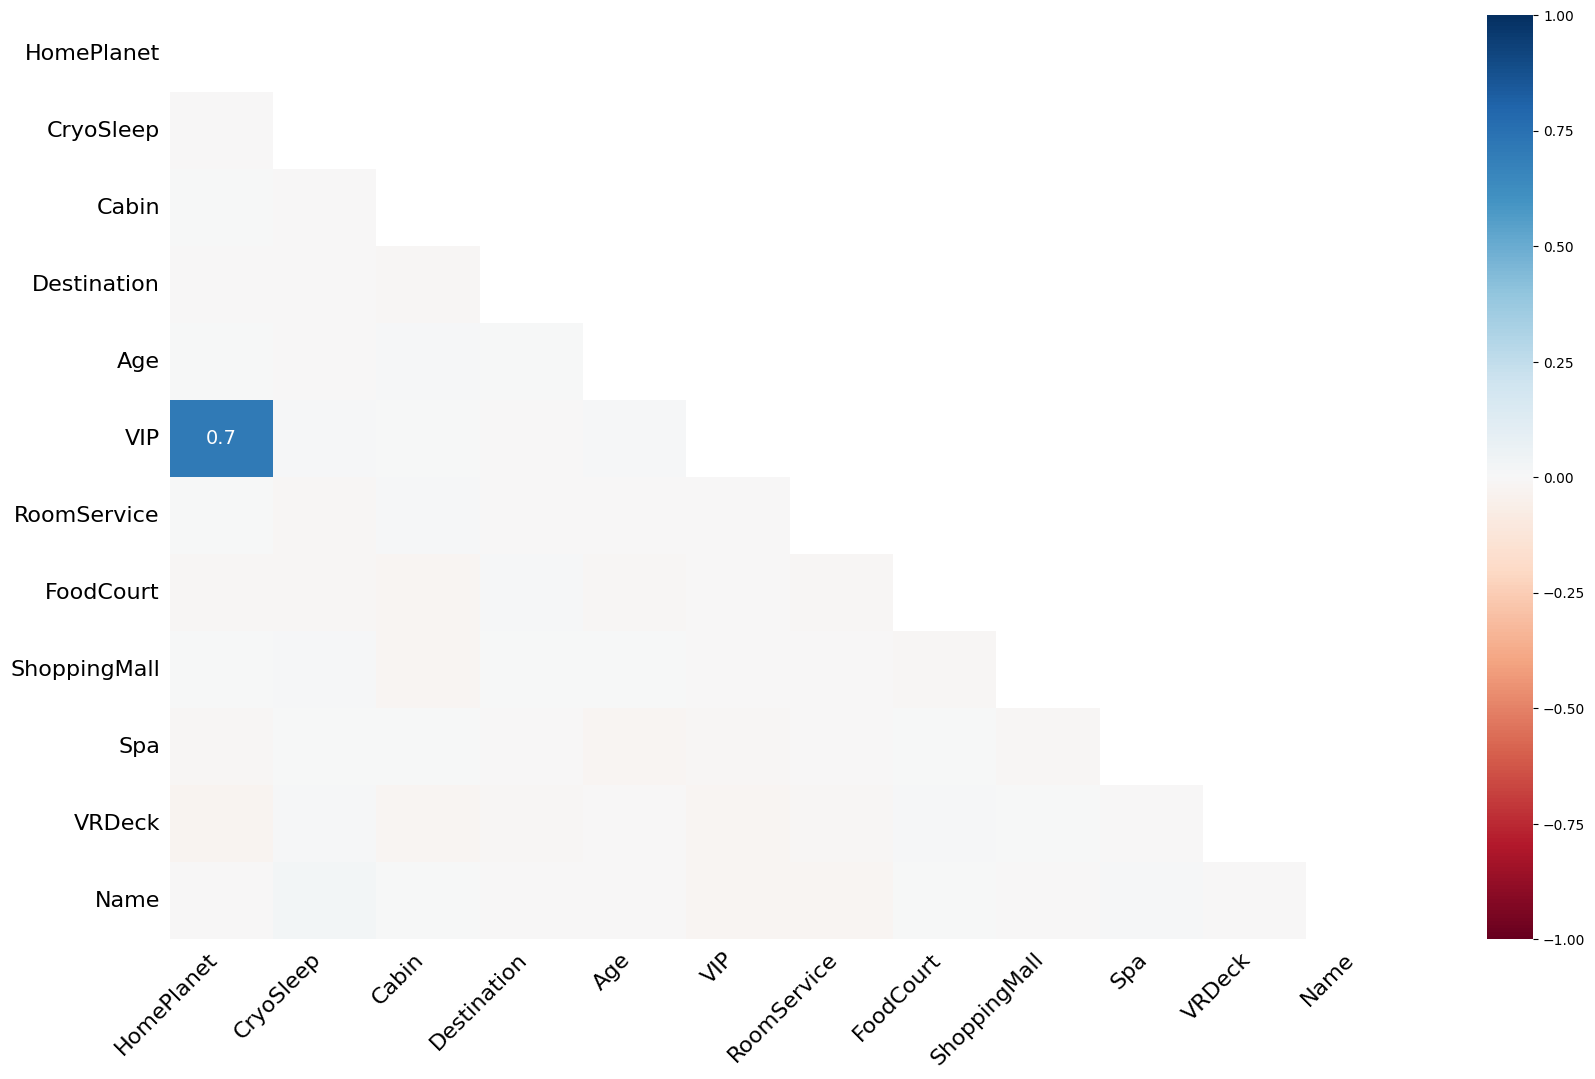

In [11]:
msno.heatmap(df)

**What does the 0.7 correlation tell us? Is the data missing at random?**

The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap. The dendrogram uses a hierarchical clustering algorithm (courtesy of `scipy`) to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.

<Axes: >

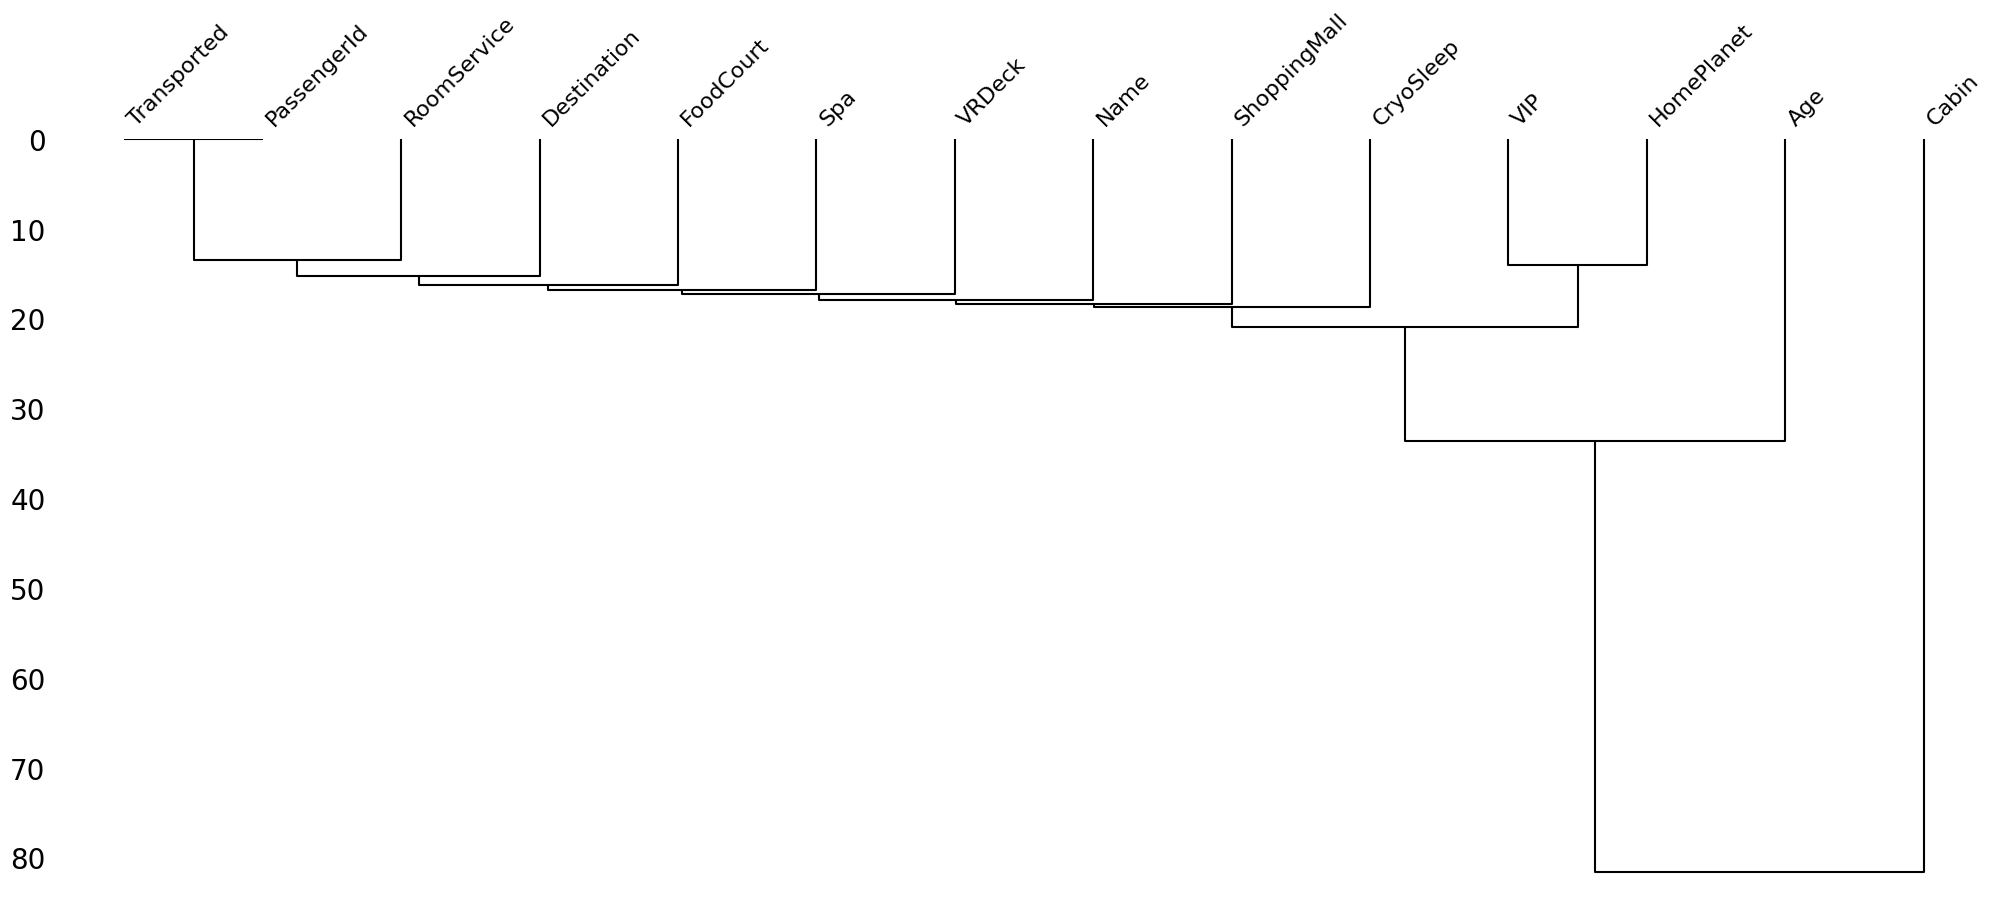

In [12]:
msno.dendrogram(df)

To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at a distance of zero fully predict one another's presence, i.e., one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and therefore present in every record.

### Missing Values Overview

We have different ways data can be missing. It is important to identify which type it is as it will change how we should deal with it. The 3 types we will consider are Missing Completely At Random (MCAR), Missing At Random (MAR), and Missing Not At Random (MNAR).

When data is MCAR, then we have that the missingness is unrelated to anything else in our data set or other relevant information. This is the cleanest form of missingness as if a truly random die was rolled for each value to determine whether a value should be marked as missing or not. This type of missing data doesn’t contain any information, and our method of remedying it is about causing the least destruction. Data are very rarely missing completely at random.

When data is MAR, then the missingness is related to the observed data but not the unobserved data. We can find this type of missingness by looking at the relationship between the missingness and the observed data we have. If we are collecting reviews from hotel stays, we might imagine that satisfaction with the stay is related to how much information we get in other fields. This is a much bigger class of missingness than MCAR and something we can find good remedies for. Most methods that try to deal with missing data assume the data is MAR.

Lastly, we have MNAR. This happens when neither MCAR nor MAR holds. Rephrased, this happens when the missingness isn’t related to anything we have observed. An example of this is an instrument that wears over time, giving higher and higher probabilities of producing missing values. If we don’t know and measure this, then we have data that are MNAR. MNAR might feel like MCAR, so our main goal is to figure out if it is or not. This should all be done at the EDA stage.

<img src="images/missing-mcar-mar-mnar.png" width="1000"/>

The 3 types of missing data MCAR, MAR, and MNAR. Missing data is represented in the first column as gray squares. The missing values don’t seem to have a pattern for MCAR. For MAR the missing values appear to align with light values in the second column. For MNAR we have that the missing values align with dark values of the unobserved data.

<img src="images/missing-data-nature.png" alt="drawing" width="500"/>

<img src="images/missing-data-causes-solution.jpg" width="500"/>

### Handling Missing Data

<img src="images/deletions.png" width="750"/>

The "pairwise deletion" method is used when values are missing completely at random, i.e, MCAR. During pairwise deletion, only the missing values are deleted. All operations in `pandas` like mean, sum, min, max, and similar, intrinsically skip missing values.

In [13]:
df["Age"].mean().item()

28.798805039615534

The "listwise deletion" method is used to remove complete rows which contain missing values. As a result, it is also called "complete case deletion". Like "pairwise deletion", "listwise deletion" is also only used for MCAR values.

In [14]:
df = df.dropna(subset=["RoomService"], axis=0)

In [15]:
df.isnull().sum()

PassengerId        0
HomePlanet       391
CryoSleep        215
Cabin           6655
Destination      179
Age              974
VIP              199
RoomService        0
FoodCourt        181
ShoppingMall     204
Spa              180
VRDeck           186
Name             199
Transported        0
dtype: int64

The major problem of "listwise deletion" method is that a major chunk of data is deleted and hence a lot of information is lost. Hence, it is advisable to use it only when the number of missing values is very small.

If a column contains a lot of missing values, say more than 70%, and the feature is not significant for the task at hand, you might want to delete that feature. However, again, it is not a good methodology to delete data.

In [16]:
df = df.drop(columns=["Cabin"])

Note: Even though we don't see it at first, the cabin feature has actually significant correlation with the target variable "Transported".

### Missing Data Imputation

#### Simple Imputation Methods

<img src="images/imputations.png" width="750"/>

In [17]:
df.head()

PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0     0001_01     Europa     False  TRAPPIST-1e  39.0  False          0.0   
1     0002_01      Earth     False  TRAPPIST-1e  24.0  False        109.0   
2     0003_01     Europa     False  TRAPPIST-1e   NaN   True         43.0   
3     0003_02     Europa     False  TRAPPIST-1e  33.0  False          0.0   
4     0004_01      Earth     False  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck               Name  Transported  
0        0.0           0.0     0.0     0.0    Maham Ofracculy        False  
1        9.0          25.0   549.0    44.0       Juanna Vines         True  
2     3576.0           0.0  6715.0    49.0      Altark Susent        False  
3     1283.0         371.0  3329.0   193.0       Solam Susent        False  
4       70.0         151.0   565.0     2.0  Willy Santantines         True

In [18]:
constant_imputer = SimpleImputer(strategy="constant", fill_value=0)

Here, we hypothesize that the missing values actually represent that people haven't spent any money on food.

In [19]:
df["FoodCourt"] = constant_imputer.fit_transform([df["FoodCourt"]])[0]

In [20]:
df.isnull().sum()

PassengerId       0
HomePlanet      391
CryoSleep       215
Destination     179
Age             974
VIP             199
RoomService       0
FoodCourt         0
ShoppingMall    204
Spa             180
VRDeck          186
Name            199
Transported       0
dtype: int64

The most frequent value of a variable is called "mode".

In [21]:
most_frequent_imputer = SimpleImputer(strategy="most_frequent")

<Axes: xlabel='HomePlanet'>

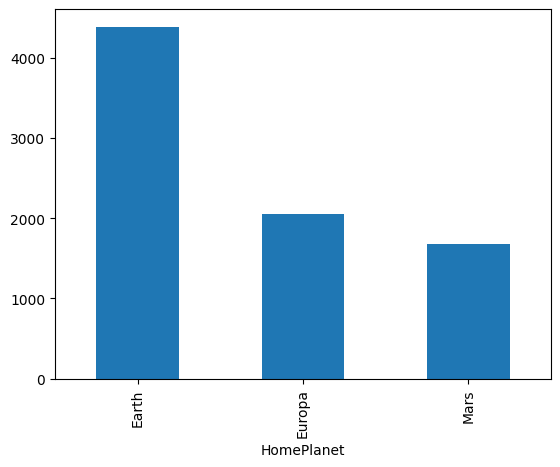

In [22]:
df["HomePlanet"].value_counts().plot.bar()

The simple imputer with `most_frequent` strategy works with numbers and strings.

We will fill missing values with "Earth" since it's the most frequent.

In [23]:
df[["HomePlanet"]] = most_frequent_imputer.fit_transform(df[["HomePlanet"]])

In [24]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep       215
Destination     179
Age             974
VIP             199
RoomService       0
FoodCourt         0
ShoppingMall    204
Spa             180
VRDeck          186
Name            199
Transported       0
dtype: int64

<Axes: ylabel='Frequency'>

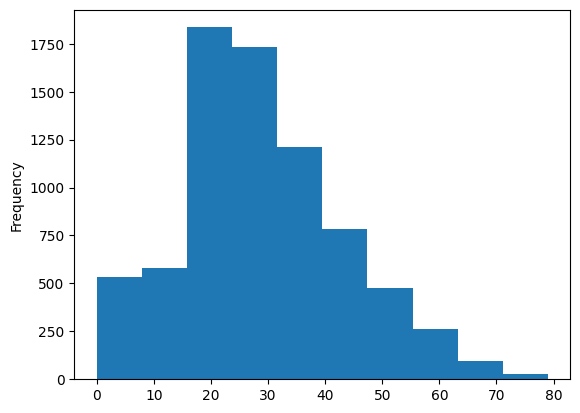

In [25]:
df["Age"].plot.hist()

In [26]:
mean_imputer = SimpleImputer(strategy="mean")

In [27]:
df["Age"].isnull().sum()

np.int64(974)

In [28]:
df[["Age"]] = mean_imputer.fit_transform(df[["Age"]])

<Axes: ylabel='Frequency'>

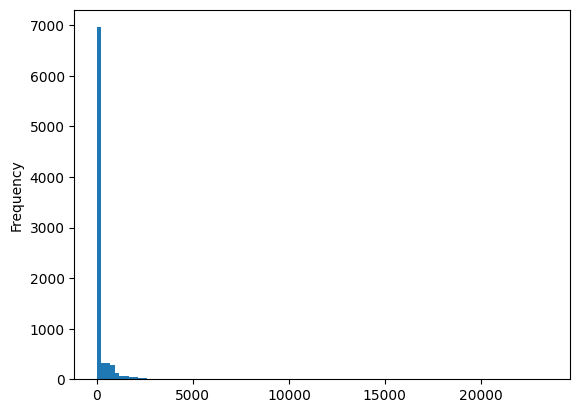

In [29]:
df["ShoppingMall"].plot.hist(bins=100)

In [30]:
df["ShoppingMall"].mean().item()

173.41911410688493

In [31]:
df["ShoppingMall"].median().item()

0.0

In [32]:
df["ShoppingMall"].mode().item()

0.0

<img src="images/mean-mode-median.png" width="750"/>

#### Advanced Imputation Methods

K-Nearest Neighbor Imputation

<img src="images/knn.png" width="750"/>

<img src="images/knn-imputation.png" width="750"/>

In [33]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep       215
Destination     179
Age               0
VIP             199
RoomService       0
FoodCourt         0
ShoppingMall    204
Spa             180
VRDeck          186
Name            199
Transported       0
dtype: int64

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

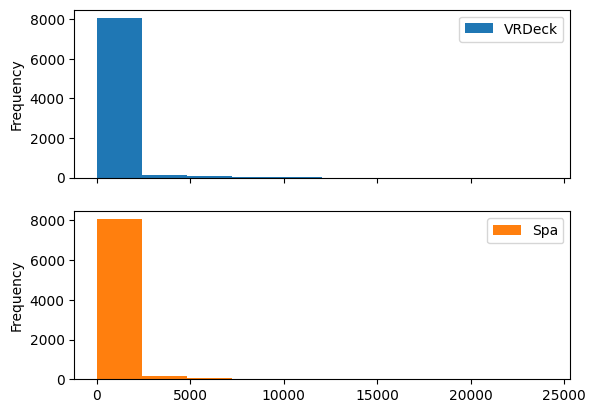

In [34]:
df[["VRDeck", "Spa"]].plot.hist(subplots=True)

<img src="images/minmaxscaler.png" width="500"/>

In [35]:
min_max_scaler = MinMaxScaler()

In [36]:
scaled_data = min_max_scaler.fit_transform(df[["VRDeck", "Spa"]])

In [37]:
knn_imputer = KNNImputer(n_neighbors=5)

In [38]:
imputed_data = knn_imputer.fit_transform(scaled_data)

In [39]:
imputed_data = min_max_scaler.inverse_transform(imputed_data)

In [40]:
df[["VRDeck", "Spa"]] = imputed_data

In [41]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep       215
Destination     179
Age               0
VIP             199
RoomService       0
FoodCourt         0
ShoppingMall    204
Spa               0
VRDeck            0
Name            199
Transported       0
dtype: int64

Multivariate Imputation by Chained Equations (MICE)

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample of the data, then takes the average of the multiple regression values and uses that value to impute the missing value. In SciKit Learn, it is implemented as follows:

<img src="images/mice.png" width="1000"/>

<Axes: >

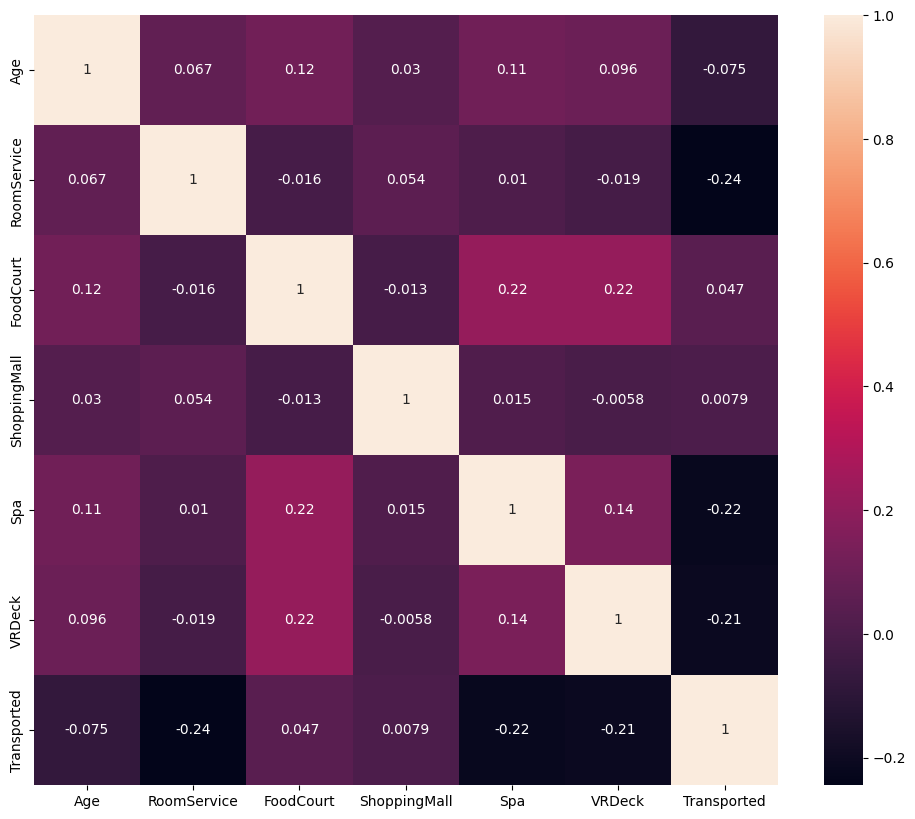

In [42]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True)

Suppose that the values in the columns "VRDeck", "FoodCourt", and "Spa" are still missing.

In [43]:
iterative_imputer = IterativeImputer()

In [44]:
imputed_data = iterative_imputer.fit_transform(df[["VRDeck", "FoodCourt", "Spa"]])

In [45]:
df[["VRDeck", "FoodCourt", "Spa"]] = imputed_data

#### Time Series Missing Data Imputation

In [46]:
df = pd.read_csv("data/03/air_quality_missing.csv")

In [47]:
df.head()

Measurement date  Station code  \
0    1/1/2017 0:00           101   
1    1/1/2017 1:00           101   
2    1/1/2017 2:00           101   
3    1/1/2017 3:00           101   
4    1/1/2017 4:00           101   

                                             Address   Latitude   Longitude  \
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
1  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
2  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
3  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
4  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   

     SO2  NO2     O3   CO  PM10  PM2.5  
0  0.004  NaN  0.002  1.2  73.0   57.0  
1  0.004  NaN  0.002  1.2  71.0   59.0  
2  0.004  NaN  0.002  1.2  70.0   59.0  
3  0.004  NaN  0.002  1.2   NaN   58.0  
4  0.003  NaN  0.002  1.2   NaN   61.0

In [48]:
df.tail()

Measurement date  Station code  \
647506  12/31/2019 19:00           125   
647507  12/31/2019 20:00           125   
647508  12/31/2019 21:00           125   
647509  12/31/2019 22:00           125   
647510  12/31/2019 23:00           125   

                                                  Address   Latitude  \
647506  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   
647507  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   
647508  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   
647509  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   
647510  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   

         Longitude    SO2    NO2     O3  CO  PM10  PM2.5  
647506  127.136792  0.003  0.028  0.013 NaN  23.0   17.0  
647507  127.136792  0.003  0.025  0.015 NaN  25.0   19.0  
647508  127.136792  0.003  0.023  0.015 NaN  24.0   17.0  
647509  127.136792  0.003  0.040  0.004 NaN  25.0   18.0  
647510  127.136792  0.003  0.037  0.005 NaN  27.0   18.0

In [49]:
df.isnull().sum()

Measurement date      0
Station code          0
Address               0
Latitude              0
Longitude             0
SO2                  74
NO2                  90
O3                   75
CO                  114
PM10                 95
PM2.5                78
dtype: int64

The most popular methods for time series missing data imputation are: `forward fill`, `backward fill`, and `interpolation`.

In [50]:
df.head()

Measurement date  Station code  \
0    1/1/2017 0:00           101   
1    1/1/2017 1:00           101   
2    1/1/2017 2:00           101   
3    1/1/2017 3:00           101   
4    1/1/2017 4:00           101   

                                             Address   Latitude   Longitude  \
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
1  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
2  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
3  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
4  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   

     SO2  NO2     O3   CO  PM10  PM2.5  
0  0.004  NaN  0.002  1.2  73.0   57.0  
1  0.004  NaN  0.002  1.2  71.0   59.0  
2  0.004  NaN  0.002  1.2  70.0   59.0  
3  0.004  NaN  0.002  1.2   NaN   58.0  
4  0.003  NaN  0.002  1.2   NaN   61.0

In [51]:
df["CO"] = df["CO"].ffill()

In [52]:
df.tail()

Measurement date  Station code  \
647506  12/31/2019 19:00           125   
647507  12/31/2019 20:00           125   
647508  12/31/2019 21:00           125   
647509  12/31/2019 22:00           125   
647510  12/31/2019 23:00           125   

                                                  Address   Latitude  \
647506  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   
647507  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   
647508  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   
647509  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   
647510  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962   

         Longitude    SO2    NO2     O3   CO  PM10  PM2.5  
647506  127.136792  0.003  0.028  0.013  0.4  23.0   17.0  
647507  127.136792  0.003  0.025  0.015  0.4  25.0   19.0  
647508  127.136792  0.003  0.023  0.015  0.4  24.0   17.0  
647509  127.136792  0.003  0.040  0.004  0.4  25.0   18.0  
647510  127.136792  0.003  0.037  0.005  0.4  27.0   18.0

In [53]:
df["NO2"] = df["NO2"].bfill()

In [54]:
df.isnull().sum()

Measurement date     0
Station code         0
Address              0
Latitude             0
Longitude            0
SO2                 74
NO2                  0
O3                  75
CO                   0
PM10                95
PM2.5               78
dtype: int64

<Axes: >

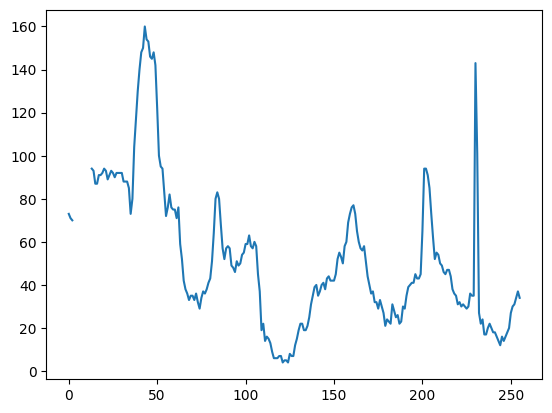

In [55]:
df["PM10"][:256].plot.line()

In [56]:
df["PM10"] = df["PM10"].interpolate(method="linear", limit_direction="both")

In [57]:
df.isnull().sum()

Measurement date     0
Station code         0
Address              0
Latitude             0
Longitude            0
SO2                 74
NO2                  0
O3                  75
CO                   0
PM10                 0
PM2.5               78
dtype: int64

## Categorical Data Encoding

In [58]:
df = pd.read_csv("data/03/spaceship_titanic.csv")

### Label Encoding

Label encoding is a method that maps the categorical levels into the integers 1 through n (or 0 through n - 1) where n is the number of levels. Note: It is mostly used for encoding the target (i.e., the predicted) variable.

In [59]:
label_encoder = LabelEncoder()

In [60]:
encoded_values = label_encoder.fit_transform(df["HomePlanet"])

In [61]:
encoded_values[:10]

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1])

In [62]:
label_encoder.classes_

array(['Earth', 'Europa', 'Mars', nan], dtype=object)

In [63]:
pd.Series(encoded_values).isnull().sum()

np.int64(0)

Note: Be careful when using `LabelEncoder` from `scikit-learn`, because it is primarly intended to be used for encoding a target variable. That's why it treats missing values as a specific categorical level. It is a better practice to use `OrdinalEncoder` with `categories="auto"`.

In [64]:
ordinal_encoder = OrdinalEncoder(categories="auto")

In [65]:
encoded_values = ordinal_encoder.fit_transform(df[["HomePlanet"]])

In [66]:
encoded_values[:10]

array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]])

In [67]:
ordinal_encoder.categories_

[array(['Earth', 'Europa', 'Mars', nan], dtype=object)]

In [68]:
df["HomePlanet"] = encoded_values

In [69]:
df["HomePlanet"].isnull().sum()

np.int64(401)

### One-Hot (Dummy) Encoding

We have some categorical variables and we want to turn them into numerical values, one of the most common ways of going about it is to create dummy variables. Dummy variables are variables that only take the values 0 and 1 to indicate the absence or presence of the levels in a categorical variable.

In [70]:
df["Destination"].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [71]:
one_hot_encoded_values = pd.get_dummies(df["Destination"])

In [72]:
one_hot_encoded_values.head()

55 Cancri e  PSO J318.5-22  TRAPPIST-1e
0        False          False         True
1        False          False         True
2        False          False         True
3        False          False         True
4        False          False         True

In [73]:
df = pd.concat([df, one_hot_encoded_values], axis=1)

In [74]:
df.head()

PassengerId  HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01         1.0     False    NaN  TRAPPIST-1e  39.0  False   
1     0002_01         0.0     False    NaN  TRAPPIST-1e  24.0  False   
2     0003_01         1.0     False  A/0/S  TRAPPIST-1e   NaN   True   
3     0003_02         1.0     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01         0.0     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  55 Cancri e  PSO J318.5-22  TRAPPIST-1e  
0        False        False          False         True  
1         True        False          False         True  
2        False        False          False         True  
3        False        False          False         True  
4         True        False          False         True

### Ordinal Encoding

This method is similar to label encoding, except that we manually specify the mapping. This method is generally used for ordinal variables as they are encoded with a natural ordering.

In [75]:
values = [["good"], ["bad"], ["neutral"], ["neutral"], ["good"], ["bad"], ["good"]]

In [76]:
ordinal_encoder = OrdinalEncoder(categories=[["bad", "neutral", "good"]])

In [77]:
encoded_values = ordinal_encoder.fit_transform(values)

In [78]:
encoded_values

array([[2.],
       [0.],
       [1.],
       [1.],
       [2.],
       [0.],
       [2.]])

### Custom Encoding

In [79]:
def encode_bool_variable(value):
    return 1 if value else -1

In [80]:
df["CryoSleep"] = df["CryoSleep"].apply(encode_bool_variable)

In [81]:
df.head()

PassengerId  HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01         1.0         -1    NaN  TRAPPIST-1e  39.0  False   
1     0002_01         0.0         -1    NaN  TRAPPIST-1e  24.0  False   
2     0003_01         1.0         -1  A/0/S  TRAPPIST-1e   NaN   True   
3     0003_02         1.0         -1  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01         0.0         -1  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  55 Cancri e  PSO J318.5-22  TRAPPIST-1e  
0        False        False          False         True  
1         True        False          False         True  
2        False        False          False         True  
3        False        False          False         True  
4         True        False          False         True